### Imports

In [127]:
import numpy as np
import pandas as pd
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
from pytensor.compile.builders import OpFromGraph
from time import perf_counter
from collections import defaultdict

### Generate dataset

In [128]:
def generate_kalman_dataset(n, N=100, seed=0):
    rng = np.random.default_rng(seed)

    # 0. Initial state and cov
    A0 = rng.normal(loc=0.0, scale=1.0, size=(n,))
    # 3. Random process noise covariance Q (PSD)
    P0_base = rng.normal(0, 1, size=(n, n))
    P0 = P0_base @ P0_base.T + np.eye(n) * 1e-3  # ensure positive definite

    # 1. T stable random transition matrix T
    T = rng.normal(0, 1, size=(n, n))
    eigvals = np.linalg.eigvals(T)
    spectral_radius = max(abs(eigvals))
    T = T / (1.1 * spectral_radius)  # shrink to ensure stability

    # 2. Random observation matrix Z
    Z = rng.normal(0, 1, size=(n, n))  # full observations (m = n)

    # 3. Random process noise covariance Q (PSD)
    Q_base = rng.normal(0, 1, size=(n, n))
    Q = Q_base @ Q_base.T + np.eye(n) * 1e-3  # ensure positive definite

    # 4. Random observation noise covariance H (PSD)
    H_base = rng.normal(0, 1, size=(n, n))
    H = H_base @ H_base.T + np.eye(n) * 1e-3

    # 5. Initial state
    x = np.zeros((N, n))
    y = np.zeros((N, n))
    x[0] = A0

    # 6. Simulate the system
    for t in range(1, N):
        w_t = rng.multivariate_normal(mean=np.zeros(n), cov=Q)
        x[t] = T @ x[t-1] + w_t

    for t in range(N):
        v_t = rng.multivariate_normal(mean=np.zeros(n), cov=H)
        y[t] = Z @ x[t] + v_t

    return {
        "T": T, "Z": Z, "Q": Q, "H": H,
        "x": x, "y": y, "A0": A0, "P0": P0
    }

### Symbolic variable

In [129]:
# Paramètres symboliques
A_sym = pt.matrix("A")         # (n, n)
H_sym = pt.matrix("H")         # (n, n)
Q_sym = pt.matrix("Q")         # (n, n)
R_sym = pt.matrix("R")         # (n, n)
T_sym = pt.matrix("T")         # (n, n)
Z_sym = pt.matrix("Z")         # (n, n)

x0_sym = pt.vector("x0")       # (n,)
y_sym = pt.matrix("y")         # (T, n) : observations

a0_sym = pt.vector("a0")        
P0_sym = pt.matrix("P0") 

data_sym = pt.matrix('data_sym')    # [T, obs_dim]

### Kalman filter with classic gradient

In [130]:
def predict(a, P, T, Q):
    a_hat = T @ a                               # x_n|n-1
    P_hat = T @ P @ T.T + Q                     # P_n|n-1
    return a_hat, P_hat

def update(y, a, P, Z, H):
    v = y - Z.dot(a)                            # z_n
    PZT = P.dot(Z.T)                            

    F = Z.dot(PZT) + H                          # S_n
    F_inv = pt.linalg.inv(F)                    # S_n^(-1)
    K = PZT.dot(F_inv)                          # K_n

    I_KZ = pt.eye(a.shape[0]) - K.dot(Z)
    a_filtered = a + K.dot(v)                   # x_n|n
    P_filtered = I_KZ @ P                       # P_n|n

    inner_term = v.T @ F_inv @ v
    _, F_logdet = pt.linalg.slogdet(F)          # log det S_n
    ll = (F_logdet + inner_term).ravel()[0]     # Loss

    return [a_filtered, P_filtered, Z.dot(a), F, ll]

def kalman_step(y, a, P, T, Z, H, Q):
    a_filtered, P_filtered, obs_mu, obs_cov, ll = update(y=y, a=a, P=P, Z=Z, H=H)
    a_hat, P_hat = predict(a=a_filtered, P=P_filtered, T=T, Q=Q)
    return [a_filtered, a_hat, obs_mu, P_filtered, P_hat, obs_cov, ll]


outputs_info = [None, a0_sym, None, None, P0_sym, None, None]

results_seq, updates = pytensor.scan(
    kalman_step,
    sequences=[data_sym],
    outputs_info=outputs_info,
    non_sequences=[T_sym, Z_sym, H_sym, Q_sym],
    strict=False,
)
# --- Loss ---
a_upd_seq, a_pred_seq, y_hat_seq, P_upd_seq, P_pred_seq, obs_cov, ll_seq = results_seq
loss = pt.sum(ll_seq)

### Custom gradient

In [131]:
def custom_grad(inp, out, out_grad):
    y, a, P, T, Z, H, Q = inp
    a_filtered, P_filtered, y_hat = out
    a_hat_grad, P_hat_grad, y_grad = out_grad

    PZT = P.dot(Z.T)
    F = Z.dot(PZT) + H

    y_hat = Z.dot(a)
    v = y - y_hat

    H_inv = pt.linalg.inv(H)
    F_inv = pt.linalg.inv(F)

    K = PZT.dot(F_inv)
    I_KZ = pt.eye(a.shape[0]) - K.dot(Z)
    
    grad_a_pred = I_KZ.T @ T.T @ a_hat_grad - 2 * Z.T @ F_inv @ v
    grad_y = K.T @ T.T @ a_hat_grad + 2 * F_inv @ v


    a_hat_grad = a_hat_grad.dimshuffle(0, 'x')
    v = v.dimshuffle(0, 'x')
    
    P_filtered_grad = T.T @ P_hat_grad @ T
    a_filtered_grad = T.T @ a_hat_grad  

    grad_P_hat = I_KZ.T @ ( P_filtered_grad + 0.5 * a_filtered_grad @ v.T @ H_inv @ Z + 0.5 * Z.T @ H_inv @ v @ a_filtered_grad.T ) @ I_KZ + Z.T @ F_inv @ Z - Z.T @ F_inv @ v @ v.T @ F_inv @ Z
    grad_Z = None
    grad_T = None
    grad_Q = P_hat_grad
    grad_H = K.T @ P_filtered_grad @ K - 0.5 * K.T @ a_filtered_grad @ v.T @ F_inv - 0.5 *  F_inv @ v @ a_filtered_grad.T @ K + F_inv - F_inv @ v @ v.T @ F_inv

    return [grad_P_hat,
            grad_a_pred,
            grad_y,
            grad_Z,
            grad_T,
            grad_Q,
            grad_H]


In [132]:
def grad_a_hat(inp, out, out_grad):
    y, a, P, T, Z, H, Q = inp
    a_hat_grad, _, _ = out_grad

    v = y - Z.dot(a)                          

    PZT = P.dot(Z.T)
    F = Z.dot(PZT) + H                          
    F_inv = pt.linalg.inv(F)
    
    K = PZT.dot(F_inv)                          
    I_KZ = pt.eye(a.shape[0]) - K.dot(Z)

    grad_a_pred = I_KZ.T @ T.T @ a_hat_grad - 2 * Z.T @ F_inv @ v

    return grad_a_pred

In [133]:
def grad_P_hat(inp, out, out_grad):
    y, a, P, T, Z, H, Q = inp
    a_hat_grad, P_hat_grad, ll_grad = out_grad

    v = y - Z.dot(a)
    v = v.dimshuffle(0, 'x')
    a_hat_grad = a_hat_grad.dimshuffle(0, 'x') 

    P_filtered_grad = T.T @ P_hat_grad @ T
    a_filtered_grad = T.T @ a_hat_grad                     

    PZT = P.dot(Z.T)
    F = Z.dot(PZT) + H

    H_inv = pt.linalg.inv(H)                         
    F_inv = pt.linalg.inv(F)
    
    K = PZT.dot(F_inv)                          
    I_KZ = pt.eye(a.shape[0]) - K.dot(Z)

    grad_P_hat = I_KZ.T @ ( P_filtered_grad + 0.5 * a_filtered_grad @ v.T @ H_inv @ Z + 0.5 * Z.T @ H_inv @ v @ a_filtered_grad.T ) @ I_KZ + Z.T @ F_inv @ Z - Z.T @ F_inv @ v @ v.T @ F_inv @ Z

    return grad_P_hat

In [134]:
def grad_y(inp, out, out_grad):
    y, a, P, T, Z, H, Q = inp
    a_hat_grad, P_h_grad, y_grad = out_grad

    y_hat = Z.dot(a)
    v = y - y_hat

    PZT = P.dot(Z.T)
    F = Z.dot(PZT) + H
    F_inv = pt.linalg.inv(F)

    K = PZT.dot(F_inv) 
    
    return K.T @ T.T @ a_hat_grad + 2 * F_inv @ v

In [11]:
def grad_Q(inp, out, out_grad):
    _, P_h_grad, _ = out_grad
    return P_h_grad

In [135]:
def grad_H(inp, out, out_grad):
    y, a, P, T, Z, H, Q = inp
    a_hat_grad, P_h_grad, y_grad = out_grad
    
    y_hat = Z.dot(a)
    v = y - y_hat

    PZT = P.dot(Z.T)
    F = Z.dot(PZT) + H
    F_inv = pt.linalg.inv(F)

    K = PZT.dot(F_inv)

    v = v.dimshuffle(0, 'x')
    a_hat_grad = a_hat_grad.dimshuffle(0, 'x') 

    a_filtered_grad = T.T @ a_hat_grad
    P_filtered_grad = T.T @ P_h_grad @ T

    return K.T @ P_filtered_grad @ K - 0.5 * K.T @ a_filtered_grad @ v.T @ F_inv - 0.5 *  F_inv @ v @ a_filtered_grad.T @ K + F_inv - F_inv @ v @ v.T @ F_inv

### Custom Kalman Filter

In [136]:
y_sym = pt.vector("y")

kalman_step_op = OpFromGraph(
    inputs=[y_sym, a0_sym, P0_sym, T_sym, Z_sym, H_sym, Q_sym],
    outputs=kalman_step(y_sym, a0_sym, P0_sym, T_sym, Z_sym, H_sym, Q_sym),
    lop_overrides=[grad_y, grad_a_hat, grad_P_hat, None, None, grad_H, grad_Q],
    inline=True
)

outputs_info = [None, a0_sym, None, None, P0_sym, None, None]

results_op, updates = pytensor.scan(
    kalman_step_op,
    sequences=[data_sym],
    outputs_info=outputs_info,
    non_sequences=[T_sym, Z_sym, H_sym, Q_sym],
    strict=False,
)
# --- Loss ---
a_upd_op, a_pred_op, y_hat_op, P_upd_op, P_pred_op, obs_cov, ll_op = results_op
loss_op = pt.sum(ll_op)

### Speed observation

In [137]:
states = [1, 5, 10, 20, 35, 50, 75, 90, 100]

In [140]:
def benchmark_kalman_gradients(loss, state_dims, N=30):
    results = defaultdict(dict)
    for _ in range(10):
        for n in state_dims:
            data = generate_kalman_dataset(n, N=N, seed=42 + n)

            # --- gradients symboliques ---
            t0 = perf_counter()
            grad_list = pt.grad(loss, [a0_sym])
            t1 = perf_counter()
            grad_symbolic_time = t1 - t0
            results[n]["grad_symbolic_time"] = grad_symbolic_time/10

            # --- compilation ---
            t0 = perf_counter()
            f_grad = pytensor.function(
                inputs=[data_sym, a0_sym, P0_sym, T_sym, Z_sym, H_sym, Q_sym],
                outputs=grad_list,
            )
            t1 = perf_counter()
            compile_time = t1 - t0
            results[n]["compile_time"] = compile_time/10

            # --- exécution ---
            t0 = perf_counter()
            _ = f_grad(
                data["y"],
                data["A0"],
                data["P0"],
                data["T"],
                data["Z"],
                data["H"],
                data["Q"],
            )
            t1 = perf_counter()
            exec_time = t1 - t0
            results[n]["exec_time"] = exec_time/10

    return results

In [141]:
results = benchmark_kalman_gradients(loss, states, N=5)

c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\numpy\linalg\_linalg.py:2383: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\numpy\linalg\_linalg.py:2383: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\numpy\linalg\_linalg.py:2383: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\numpy\linalg\_linalg.py:2383: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\numpy\linalg\_linalg.py:2383: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\numpy\linalg\_linalg.py:2383: RuntimeWarni

In [ ]:
results_op = benchmark_kalman_gradients(loss_op, states, N=5)

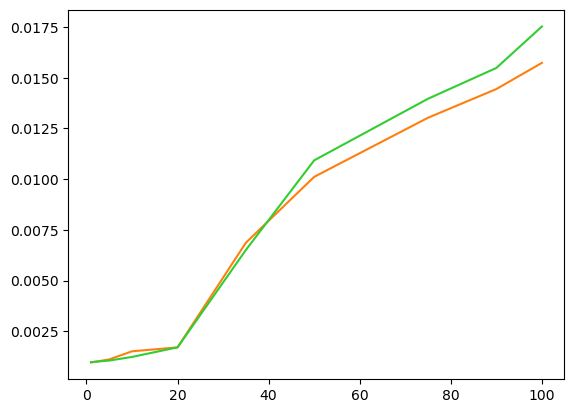

In [ ]:
tps_execution = [results[i]["exec_time"] for i in states]
tps_execution_op = [results_op[i]["exec_time"] for i in states]
plt.plot(states, tps_execution, color="C1")
plt.plot(states, tps_execution_op, color="limegreen")


### Handmade Numpy Backpropagation 

In [81]:
def compute_grad(observations, a0, P0, a_pred_seq, P_pred_seq, Z, H, T):
    # Constant
    SHAPE_a0 = a0.shape[0]
    NB_obs = len(observations)

    # Initialisation for the backprop
    PZT = P_pred_seq[-2].dot(Z.T)
    F = Z.dot(PZT) + H
    F_inv = np.linalg.solve(F, np.eye(F.shape[0]))
    
    grad = [0 for _ in range(NB_obs)]
    grad[-1] = - 2 * Z.T @ F_inv @ (observations[-1] - Z @ a_pred_seq[-2])

    # Backprop
    for i in range(3, NB_obs+1):

        PZT = P_pred_seq[-i].dot(Z.T)
        F = Z.dot(PZT) + H
        F_inv = np.linalg.solve(F, np.eye(F.shape[0]))

        K = PZT.dot(F_inv)
        I_KZ = np.eye(SHAPE_a0) - K.dot(Z)

        grad[1-i] = I_KZ.T @ T.T @ grad[2-i] - (2 * Z.T @ F_inv @ (observations[1-i] - Z @ a_pred_seq[-i])).T   

    # Last iter with a0/P0
    PZT = P0.dot(Z.T)
    F = Z.dot(PZT) + H
    F_inv = np.linalg.solve(F, np.eye(F.shape[0]))

    K = PZT.dot(F_inv)
    I_KZ = np.eye(SHAPE_a0) - K.dot(Z)

    grad[0] = I_KZ.T @ T.T @ grad[1] - (2 * Z.T @ F_inv @ (observations[0] - Z @ a0)).T

    return grad

In [108]:
def benchmark_kalman_gradients_np(loss, a_pred_seq, P_pred_seq, state_dims, N=3):
    results = defaultdict(dict)
    kalman_fn = pytensor.function(inputs=[data_sym, a0_sym, P0_sym, T_sym, Z_sym, H_sym, Q_sym],
                                outputs=(a_pred_seq, P_pred_seq))
    
    for _ in range(10):
        for n in state_dims:
            data = generate_kalman_dataset(n, N=N, seed=42 + n)

            # --- forward pass ---
            t0 = perf_counter()
            a_pred, P_pred = kalman_fn(data["y"],
                                        data["A0"],
                                        data["P0"],
                                        data["T"],
                                        data["Z"],
                                        data["H"],
                                        data["Q"],)
            t1 = perf_counter()
            forward_pass = t1 - t0
            results[n]["Forward pass"] = forward_pass/10

            # --- Backprop ---
            t0 = perf_counter()
            grad = compute_grad(data["y"],
                    data["A0"],
                    data["P0"],
                    a_pred,
                    P_pred,
                    data["Z"],
                    data["H"],
                    data["T"],)
            t1 = perf_counter()
            compile_time = t1 - t0
            results[n]["Backprop"] = compile_time/10

    return results

In [121]:
results_np = benchmark_kalman_gradients_np(loss, a_pred_seq, P_pred_seq, states, N=30)

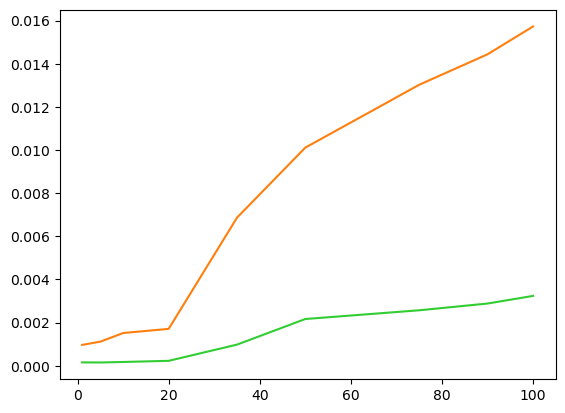

In [122]:
tps_execution = [results[i]["exec_time"] for i in states]
tps_execution_np = [results_np[i]["Backprop"] + results_np[i]["Forward pass"] for i in states]
plt.plot(states, tps_execution, color="C1")
plt.plot(states, tps_execution_np, color="limegreen")

In [124]:
print(results[20]["exec_time"])

0.0017101200064644217


In [126]:
print(results_np[20]["Backprop"] + results_np[20]["Forward pass"])

0.00022822999162599444
